In [1]:
%matplotlib inline
from solveFull import linearSolve_krylov as linearSolve
import numpy as np, matplotlib.pyplot as plt
import pystokes

In [2]:
def rotation(vector,alpha, beta, gamma):
    rotmat = np.array([[np.cos(beta)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma) 
                        - np.cos(alpha)*np.sin(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)
                        + np.sin(alpha)*np.sin(gamma)],
                       [np.cos(beta)*np.sin(gamma),
                        np.sin(alpha)*np.sin(beta)*np.sin(gamma) + np.cos(alpha)*np.cos(gamma),
                        np.cos(alpha)*np.sin(beta)*np.sin(gamma) - np.sin(alpha)*np.cos(gamma)],
                       [-np.sin(beta),
                        np.sin(alpha)*np.cos(beta),
                        np.cos(alpha)*np.cos(beta)]])
    return np.dot(rotmat, vector)

In [3]:
# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## squirmer
D0  = 1.0      
S0  = 3/50*D0    # beta = 1 (positive beta is a puller (negative V2s)) - not sure which sign!

In [4]:
## initialise 
#initial position
r = np.array([-1.5,1.5, 0.,0. , 0., 0.])

#initial orientation
p = np.array([0., 0., 0.,0., 1.,1.])

##rotate particles 50deg towards each other
p[::Np] = rotation(p[::Np], 0., 25*2*np.pi/360, 0.)
p[1::Np] = rotation(p[1::Np], 0., -25*2*np.pi/360, 0.)


# initial slip modes
S = np.zeros(9*Np)
D = np.zeros(3*Np)
for i in range(Np):
    ## S in order: xx, xy, xz, yx, yy, yz, zx, zy, zz
    S[i]       = S0*(3*p[i]*p[i] -1.)
    S[i + Np]  = S0*(3*p[i]*p[i+Np])
    S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
    S[i + 3*Np]= S0*(3*p[i+Np]*p[i])
    S[i + 4*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
    S[i + 5*Np]= S0*(3*p[i+Np]*p[i+2*Np]) 
    S[i + 6*Np]= S0*(3*p[i+2*Np]*p[i])
    S[i + 7*Np]= S0*(3*p[i+2*Np]*p[i+Np])
    S[i + 8*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)
    
    D[i]       = D0*p[i]
    D[i+Np]    = D0*p[i+Np]
    D[i+2*Np]  = D0*p[i+2*Np]

In [5]:
def rhs(rp): ##change this to give polarisation directly
    """
    Function that gives rhs for equations dr/dt=v and dp/dt= o x p
    """
    
    #position and angle theta (relative to initial angle)
    r = rp[0:3*Np]; p = rp[3*Np:6*Np]
    
    ## make sure orientations remain unit length
    norm_p1 = np.dot(p[::Np],p[::Np])
    norm_p2 = np.dot(p[1::Np],p[1::Np])
    
    p[::Np] = p[::Np]/np.sqrt(norm_p1)
    p[1::Np] = p[1::Np]/np.sqrt(norm_p2)
    
    
    F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)
    
    for i in range(Np):          
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0 
        
        T[i]      = 0.0
        T[i+Np]   = 0.0
        T[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
        
        S[i]       = S0*(3*p[i]*p[i] -1.)
        S[i + Np]  = S0*(3*p[i]*p[i+Np])
        S[i + 2*Np]= S0*(3*p[i]*p[i+2*Np])
        S[i + 3*Np]= S0*(3*p[i+Np]*p[i])
        S[i + 4*Np]= S0*(3*p[i+Np]*p[i+Np]-1.)
        S[i + 5*Np]= S0*(3*p[i+Np]*p[i+2*Np]) 
        S[i + 6*Np]= S0*(3*p[i+2*Np]*p[i])
        S[i + 7*Np]= S0*(3*p[i+2*Np]*p[i+Np])
        S[i + 8*Np]= S0*(3*p[i+2*Np]*p[i+2*Np] - 1.)
        
        D[i]       = D0*p[i]
        D[i+Np]    = D0*p[i+Np]
        D[i+2*Np]  = D0*p[i+2*Np]

    
    #update repulsive force at position r
    forces.lennardJones(F, r, lje=5.0, ljr=2.1*b)
    
    #update velocity and angular velocity at r, acted on by F and T, and with slip modes S an D
    ls.RBM(v, o, r, F, T, S, D)
    
    dpdt = np.zeros(3*Np)
    
    for i in range(Np):
        dpdt[i]      = o[i+Np]*p[i+2*Np] - o[i+2*Np]*p[i+Np]    
        dpdt[i+Np]   = o[i+2*Np]*p[i   ] - o[i     ]*p[i+2*Np]  
        dpdt[i+2*Np] = o[i     ]*p[i+Np] - o[i+Np  ]*p[i]

    #return velocity and angular velocity cross orientation as right-hand side
    return np.concatenate( (v,dpdt) )

In [6]:
def simulate(rth0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=100000, **kwargs):
    
    def dxdtEval(rth,t):
        return rhs(rth)
    
    if integrator=='BDF': ## weird handling for this method
        from scipy.integrate import BDF
        X = BDF(lambda t, xt: dxdtEval(xt,t), Ti, rth0, Tf)
        
    if integrator=='odeint':
        from scipy.integrate import odeint
        time_points=np.linspace(Ti, Tf, Npts+1);
        X = odeint(dxdtEval, rth0, time_points, mxstep=maxNumSteps, **kwargs)
        
    if integrator=='solve_ivp':
        from scipy.integrate import solve_ivp
        time_points=np.linspace(Ti, Tf, Npts+1)                                                          
        X = solve_ivp(lambda t, xt: dxdtEval(xt,t), [0,Tf], rth0, 
                         t_eval=None, **kwargs)
        
    return X

In [7]:
# F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

# ls = linearSolve(b, Np, eta, tolerance=1e-10)
# ls.RBM(v, o, r, F, T, S, D)

In [8]:
%%time
#initiallize system and forces
ls = linearSolve(b, Np, eta)
forces  = pystokes.forceFields.Forces(particles=Np)

#simulate the resulting system
rp0 = np.concatenate((r,p))
Tf = 300.
Npts = 10

X = simulate(rp0, Tf, Npts, rhs, integrator='solve_ivp', Ti=0, maxNumSteps=1000,
             method='BDF')
X.message

CPU times: user 3min 34s, sys: 89.6 ms, total: 3min 34s
Wall time: 3min 15s


'The solver successfully reached the end of the integration interval.'

In [9]:
pos = X.y.T[:,0:3*Np]
times = X.t

In [10]:
pos1 = pos[:,::Np]
pos2 = pos[:,1::Np]

In [11]:
plt.rcParams.update({'font.size': 17})

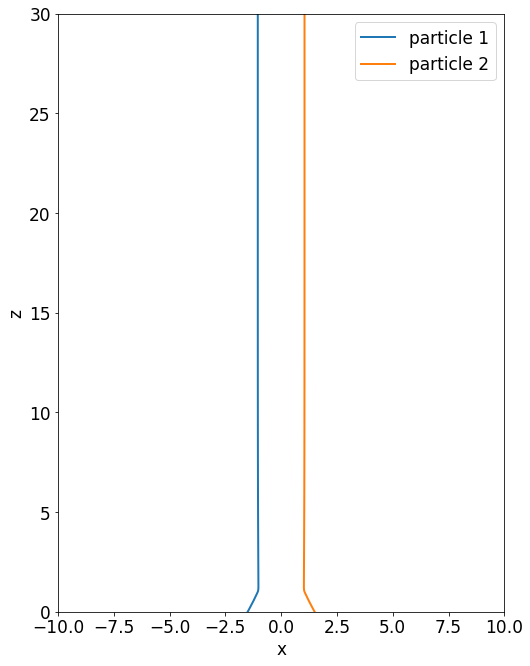

In [12]:
##x-y plot like in Ishikawa
plt.figure(figsize=(8,11))
plt.plot(pos1[:,0], pos1[:,2], label='particle 1', lw=2)
plt.plot(pos2[:,0], pos2[:,2], label='particle 2', lw=2)
plt.xlabel('x')
plt.ylabel('z')
plt.ylim(0,30)
plt.xlim(-10,10)
plt.legend()
plt.show()

In [13]:
## minimum distance between the two particles
rmin = np.amin(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmax = np.amax(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2))
rmin, rmax

(2.0372946570420027, 3.0)

In [14]:
minIndex = np.where(np.sqrt((pos1[:,0]-pos2[:,0])**2 + (pos1[:,1]-pos2[:,1])**2 + (pos1[:,2]-pos2[:,2])**2)==rmin)
#minIndex[0][0] -= 18
xik,yik,zik = (pos1[minIndex,:]-pos2[minIndex,:])[0][0]
minIndex

(array([17]),)

In [15]:
xik,yik,zik ##they go out of plane? not anymore! 

(-2.0372946570420027, 0.0, -3.483879851273741e-13)

In [16]:
##why does Krylov solver go so wrong? seems to introduce numerical error. 

## Try symmetry factor corrected matrix elements with a direct solver? 

In [17]:
print(pos1[:,0] + pos2[:,0])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.76996262e-15  1.42330592e-13
  1.57207580e-13  1.59872116e-13  1.58761893e-13  1.58095759e-13
  1.62536651e-13  1.77191595e-13  1.93844940e-13  1.69642078e-13
  1.40332190e-13  2.35811370e-13  6.59472477e-14  3.30624417e-13
  1.21191945e-12  1.64379621e-12  2.00306438e-12  2.40141240e-12
  2.91899838e-12  4.28079794e-12  6.21480645e-12  9.15023612e-12
  1.29740663e-11  2.97752933e-11  6.69164724e-11  1.50677693e-10
  3.17030624e-10  6.08737727e-10  1.19476717e-09  1.97684047e-09
  3.45454154e-09  6.43757092e-09  1.68420677e-08  4.13661720e-08
  9.34905608e-08  1.94936255e-07 -2.82325797e-06  2.79616022e-05
  3.44834581e-05]


In [18]:
orientations = X.y.T[:,3*Np:6*Np]
or1 = orientations[:,::Np]
or2 = orientations[:,1::Np]

In [19]:
or1[:,0] + or2[:,0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.11022302e-15,  2.22044605e-16,  4.44089210e-16,  4.44089210e-16,
        1.39888101e-14, -2.31481501e-14, -6.94444502e-14, -9.97535388e-14,
       -2.89490654e-14,  1.52072799e-13,  3.32261996e-13,  3.47916140e-13,
        1.47389045e-13,  2.86918059e-13,  6.20097723e-13,  1.02135314e-12,
        1.44679407e-12,  2.44600867e-12,  3.64723529e-12,  5.04009334e-12,
        6.58979815e-12,  1.13315746e-11,  2.14657458e-11,  4.95987695e-11,
        1.14255300e-10,  2.29573527e-10,  4.27477109e-10,  6.04326311e-10,
        8.74037676e-10,  1.57240732e-09,  4.45155579e-09,  1.07713620e-08,
        2.22070540e-08,  4.21002683e-08, -4.70438530e-07,  4.84766964e-06,
        5.96918351e-06])

In [20]:
or1[:,2] - or2[:,2]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.88657986e-15, -1.11022302e-16, -2.22044605e-16, -1.11022302e-16,
        1.10911280e-13,  1.24789068e-13,  8.78186412e-14, -1.83963955e-13,
       -2.66564548e-13,  3.93796107e-13,  1.05138120e-13,  1.01108011e-12,
        4.37871961e-13,  8.42659276e-14, -1.45439216e-14, -2.62012634e-14,
        1.57651669e-14, -8.88178420e-16,  2.14273044e-14,  1.68198788e-13,
        4.27324842e-13,  1.35513822e-12,  1.62425629e-13, -1.43007828e-12,
        7.40951744e-12,  3.51519924e-11,  1.06440634e-10,  1.96741623e-10,
       -2.09993134e-11, -1.42092116e-10,  7.38781814e-10,  1.78888548e-09,
        3.68882547e-09,  6.99289104e-09, -7.82484298e-08,  8.06296804e-07,
        9.91366953e-07])

In [21]:
X.nfev

127

In [22]:
S[::Np]

array([-0.05516854, -0.        , -0.02909157, -0.        , -0.06      ,
        0.        , -0.02909157,  0.        ,  0.11516854])

In [23]:
S[1::Np]

array([-0.05516819,  0.        ,  0.0290926 ,  0.        , -0.06      ,
        0.        ,  0.0290926 ,  0.        ,  0.11516819])

In [24]:
or1[:,0]

array([ 0.42261826,  0.42261578,  0.42261329,  0.42258844,  0.42256357,
        0.42231332,  0.42206127,  0.41943587,  0.41660541,  0.4135464 ,
        0.39227536,  0.35723822,  0.35151508,  0.34537266,  0.33888545,
        0.33217752,  0.31968469,  0.30721194,  0.29491955,  0.27156762,
        0.24914673,  0.17894498,  0.11920385,  0.06931158,  0.02704516,
        0.00890181, -0.0074907 , -0.02230603, -0.03569127, -0.05828589,
       -0.0768001 , -0.09199604, -0.10448874, -0.12652326, -0.14038682,
       -0.14904545, -0.15442413, -0.15781231, -0.16037265, -0.16185664,
       -0.16272044, -0.16321349, -0.16358269, -0.16371814, -0.16378942,
       -0.16382637, -0.16385604, -0.16383598, -0.16383353])

In [25]:
pos1[:,2]

array([0.00000000e+00, 6.64541554e-05, 1.32908389e-04, 7.97457663e-04,
       1.46201484e-03, 8.10828535e-03, 1.47553575e-02, 8.12723046e-02,
       1.47879153e-01, 2.14585253e-01, 5.68096597e-01, 9.27524210e-01,
       9.73032606e-01, 1.01872187e+00, 1.06458228e+00, 1.11058520e+00,
       1.19563262e+00, 1.28095514e+00, 1.36649705e+00, 1.53679769e+00,
       1.70765214e+00, 2.29350540e+00, 2.88106923e+00, 3.46826319e+00,
       4.07200517e+00, 4.37399322e+00, 4.67532898e+00, 4.97600007e+00,
       5.27600646e+00, 5.86247289e+00, 6.44664489e+00, 7.02876678e+00,
       7.60909882e+00, 9.01462471e+00, 1.04138631e+01, 1.18090062e+01,
       1.32015164e+01, 1.45923429e+01, 1.63570215e+01, 1.81207210e+01,
       1.98838526e+01, 2.16466714e+01, 2.46633747e+01, 2.76798813e+01,
       3.06963297e+01, 3.37127453e+01, 4.42353898e+01, 5.47579911e+01,
       5.59315397e+01])